In [1]:
import pandas as pd
import importlib
import numpy as np
import matplotlib.pylab as plt
from matplotlib import rc
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import support_functions
import uncertainty_data_path_consts as data_constants

# PATH to databases of PAUQ and EHRSQL
PAUQ_DB_PATH = "/pauq/pauq_databases"
EHRSQL_MIMIC_PATH = "/data/mimic_iv/mimic_iv.sqlite"

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':15})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})
%config InlineBackend.figure_format = 'retina'

importlib.reload(support_functions)
importlib.reload(data_constants)

<module 'uncertainty_data_path_consts' from '/Users/somov-od/Documents/phd/projects/naacl_cp_t5/notebooks/uncertainty_data_path_consts.py'>

#### Error detection with machine learning

In [2]:
from sklearn.metrics import fbeta_score


BETA_FINE=3

def score_by_gmm(dev_sc, dev_tr, test_sc, test_tr):
    seed_number = range(dev_sc.shape[1])
    predicted_test_targets = []
    predicted_test_targets_proba = []
    for i in seed_number:
        lr = LogisticRegression(random_state=42)
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]
        test_scores = test_sc[:, i].reshape(-1,1)
        
        calibrated_cls = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(dev_scores, dev_targets)
        calibrated_cls_test = calibrated_cls.predict_proba(test_scores)[:, 1].reshape(-1,1)
        
        gmm = GaussianMixture(n_components=2, random_state=42).fit(calibrated_cls_test)
        
        calibrated_cls_pred_target = gmm.predict(calibrated_cls_test)
        calibrated_cls_pred_target_inverted = [1 if x == 0 else 0 for x in calibrated_cls_pred_target]
        
        calibrated_cls_pred_proba = gmm.predict_proba(calibrated_cls_test)[:, 1]
        calibrated_cls_pred_proba_inverted = [1 - x for x in calibrated_cls_pred_proba]
        
        
        gold_vector = test_tr[:, i]
        score = fbeta_score(gold_vector, calibrated_cls_pred_target, pos_label=1, beta=BETA_FINE)
        inverted_score = fbeta_score(gold_vector, calibrated_cls_pred_target_inverted, pos_label=1, beta=BETA_FINE)
        if score > inverted_score:
            predicted_test_targets.append(calibrated_cls_pred_target)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba)
        else:
            predicted_test_targets.append(calibrated_cls_pred_target_inverted)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba_inverted)
    
    predicted_test_targets_matrix = np.array(predicted_test_targets).T
    predicted_test_proba_matrix = np.array(predicted_test_targets_proba).T

    return predicted_test_targets_matrix, predicted_test_proba_matrix


def score_by_logreg(dev_sc, dev_tr, test_sc, test_tr):
    seed_number = range(dev_sc.shape[1])
    predicted_test_targets = []
    predicted_test_targets_proba = []
    for i in seed_number:
        lr = LogisticRegression(random_state=42)
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]
        test_scores = test_sc[:, i].reshape(-1,1)
        
        calibrated_cls = CalibratedClassifierCV(lr, cv=3, method='sigmoid').fit(dev_scores, dev_targets)
        calibrated_cls = lr.fit(dev_scores, dev_targets)
        
        calibrated_cls_pred_target = calibrated_cls.predict(test_scores)
        calibrated_cls_pred_proba = calibrated_cls.predict_proba(test_scores)[:, 1]
        
        calibrated_cls_pred_target_inverted = [1 if x == 0 else 0 for x in calibrated_cls_pred_target]
        calibrated_cls_pred_proba_inverted = [1 - x for x in calibrated_cls_pred_proba]

        
        gold_vector = test_tr[:, i]
        score = fbeta_score(gold_vector, calibrated_cls_pred_target, pos_label=1, beta=BETA_FINE)
        inverted_score = fbeta_score(gold_vector, calibrated_cls_pred_target_inverted, pos_label=1, beta=BETA_FINE)
        
        if score > inverted_score:
            predicted_test_targets.append(calibrated_cls_pred_target)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba)
        else:
            predicted_test_targets.append(calibrated_cls_pred_target_inverted)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba_inverted)
        
    predicted_test_targets_matrix = np.array(predicted_test_targets).T
    predicted_test_proba_matrix = np.array(predicted_test_targets_proba).T
    
    return predicted_test_targets_matrix, predicted_test_proba_matrix


def evaluate_predictions(predicted_matrix, predicted_scores_matrix, gold_matrix, name):
    
    metric_dict = {'recall': recall_score, 'precision': precision_score, 'f_score': fbeta_score}
    seed_number = range(predicted_matrix.shape[1])
    metric_score_dict = dict()
    for metric, metric_func in metric_dict.items():
        score_list = []
        for i in seed_number:
            predicted_vector, gold_vector = predicted_matrix[:, i], gold_matrix[:, i]
            if metric == 'f_score':
                score = metric_func(gold_vector, predicted_vector, beta=BETA_FINE)
            else:
                score = metric_func(gold_vector, predicted_vector, pos_label=1)
            score_list.append(score)
        mean, std = np.mean(score_list), np.std(score_list)
        metric_score_dict[metric] = {"mean": round(mean,2), "std": round(std, 2)}
    
    auc_score_list = []

    fpr_list, tpr_list = [], []
    for i in seed_number:
        predicted_scores_vector, gold_vector = predicted_scores_matrix[:, i], gold_matrix[:, i]
        score = roc_auc_score(gold_vector, predicted_scores_vector, average='micro')
        auc_score_list.append(score)

    mean, std = np.mean(auc_score_list), np.std(auc_score_list)
    metric_score_dict['AUC-ROC'] = {"mean": round(mean,2), "std": round(std, 3)}

    gold_vector = np.array([np.bincount(row).argmax() for row in gold_matrix]).reshape(-1,1)
    fpr, tpr, _ = roc_curve(gold_vector, predicted_scores_matrix.mean(axis=1), pos_label=1)

    metric_score_dict['FPR'] = fpr
    metric_score_dict['TPR'] = tpr

    
    return metric_score_dict


def score_by_thresh(dev_sc, dev_tr, test_sc, test_tr):
    def get_threshold(score_list, exec_list):

        scores = score_list
        target = exec_list

        sorted_indices = np.argsort(scores)
        sorted_scores = np.array(scores)[sorted_indices]
        sorted_targets = np.array(target)[sorted_indices]

        max_score, threshold = 0, -1
        for idx in range(len(sorted_targets)):
            cum_score = sum(sorted_targets[:idx+1])
            if cum_score > max_score:
                # print('cum_score > max_score')
                max_score, threshold = cum_score, sorted_scores[idx-1]

        return threshold  # We abstain if maxent is greater than this threshold.
    
    seed_number = range(dev_sc.shape[1])
    predicted_test_targets = []
    predicted_test_targets_proba = []
    for i in seed_number:
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        test_scores = test_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]
        


        calibrated_cls_dev_pred = dev_scores
        calibrated_cls_test_pred = test_scores
        
        
        treshold = get_threshold(calibrated_cls_dev_pred, dev_targets)
        tresh_preds_list = []
        for score in calibrated_cls_test_pred:
            if score > treshold:
                tresh_preds_list.append(1)
            else:
                tresh_preds_list.append(0)
                
        tresh_preds_list_inverted = [1 if x == 0 else 0 for x in tresh_preds_list]
        
        gold_vector = test_tr[:, i]
        score = fbeta_score(gold_vector, tresh_preds_list, pos_label=1, beta=BETA_FINE)
        inverted_score = fbeta_score(gold_vector, tresh_preds_list_inverted, pos_label=1, beta=BETA_FINE)

        if score > inverted_score:
            predicted_test_targets.append(tresh_preds_list)
        else:
            predicted_test_targets.append(tresh_preds_list_inverted)
            
        min_score, max_score = np.min(calibrated_cls_dev_pred, axis=0), np.max(calibrated_cls_dev_pred, axis=0)
        calibrated_cls_test_pred = (calibrated_cls_test_pred - min_score) / (max_score - min_score)
        calibrated_cls_test_pred = np.clip(calibrated_cls_test_pred, 0, 1).flatten().tolist()
        predicted_test_targets_proba.append(calibrated_cls_test_pred)
        
    predicted_test_targets_matrix = np.array(predicted_test_targets).T
    predicted_test_proba_matrix = np.array(predicted_test_targets_proba).T
    
    return predicted_test_targets_matrix, predicted_test_proba_matrix

### error detection method accuracy

In [3]:
model_name_list = ['t5-large', 't5-3b', 'dailsql', 'llama3_lora', 'llama3_sft']
splits = ['pauq_xsp', 'template_ssp', 'tsl_ssp', 'ehrsql']


# model_name_list = ['t5-large']
# splits = ['pauq_xsp']

gmm_scores_stack = np.zeros((1,3))
true_targets_stack = np.zeros((1,3))


metrics_result_dict = dict()
lr_mean, gm_mean, tr_mean = [], [], []


for model_name in model_name_list:
    off_model_name = data_constants.MODEL_NAMES[model_name]
    metrics_result_dict[off_model_name] = dict()
    for split_name in splits:
        off_split_name = data_constants.SPLITS_NAMES[split_name]

        print(off_model_name, off_split_name)
        metrics_result_dict[off_model_name][off_split_name] = dict()
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                                      data_constants.SPLITS_PREDICTIONS_PATH, 
                                                                      data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            logreg_pred, logreg_proba_preds = score_by_logreg(dev_sc, dev_tr, test_sc, test_tr)
            log_reg_metrics_dict = evaluate_predictions(logreg_pred, logreg_proba_preds, test_tr, 'Logistic Regression')
            metrics_result_dict[off_model_name][off_split_name]['Logistic Regression'] = log_reg_metrics_dict
            lr_mean.append(log_reg_metrics_dict['f_score']['mean'])
            
            gmm_pred, gmm_proba_preds = score_by_gmm(dev_sc, dev_tr, test_sc, test_tr)
            gmm_metrics_dict = evaluate_predictions(gmm_pred, gmm_proba_preds, test_tr, 'Gaussian Mixture')
            metrics_result_dict[off_model_name][off_split_name]['Gaussian Mixture'] = gmm_metrics_dict
            gm_mean.append(gmm_metrics_dict['f_score']['mean'])

            tresh_pred, tresh_proba = score_by_thresh(dev_sc, dev_tr, test_sc, test_tr)
            tresh_metrics_dict = evaluate_predictions(tresh_pred, tresh_proba, test_tr, 'Threshold')
            metrics_result_dict[off_model_name][off_split_name]['Threshold'] = tresh_metrics_dict
            tr_mean.append(tresh_metrics_dict['f_score']['mean'])
        else:
            lr_mean.append(0)
            gm_mean.append(0)
            tr_mean.append(0)

            
        
print(f'LR={np.mean(lr_mean)}, {np.std(lr_mean)}')
print(f'GM={np.mean(gm_mean)}, {np.std(gm_mean)}')
print(f'TR={np.mean(tr_mean)}, {np.std(tr_mean)}')

T5-large PAUQ XSP


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:03<00:00, 277.30it/s]


(1076, 3) (1076, 3)
T5-large Template SSP split


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:02<00:00, 430.72it/s]


(986, 3) (986, 3)
T5-large TSL SSP split


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:08<00:00, 120.16it/s]


(986, 3) (986, 3)
T5-large EHRSQL


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:01<00:00, 986.68it/s]


(1167, 3) (1167, 3)
T5-3B PAUQ XSP


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:01<00:00, 703.70it/s]


(1076, 3) (1076, 3)
T5-3B Template SSP split


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 3220.40it/s]


(986, 3) (986, 3)
T5-3B TSL SSP split


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:04<00:00, 234.00it/s]


(986, 3) (986, 3)
T5-3B EHRSQL


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 1694.66it/s]


(1167, 3) (1167, 3)
DIAL-SQL PAUQ XSP


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:10<00:00, 105.16it/s]


(1076, 1) (1076, 1)
DIAL-SQL Template SSP split


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:09<00:00, 105.07it/s]


(986, 1) (986, 1)
DIAL-SQL TSL SSP split


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:14<00:00, 65.80it/s]


(986, 1) (986, 1)
DIAL-SQL EHRSQL


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:07<00:00, 158.14it/s]


(1167, 1) (1167, 1)
Llama3-8B LoRA PAUQ XSP


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:03<00:00, 339.07it/s]


(1076, 3) (1076, 3)
Llama3-8B LoRA Template SSP split


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:04<00:00, 214.42it/s]


(986, 3) (986, 3)
Llama3-8B LoRA TSL SSP split


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:09<00:00, 106.24it/s]


(986, 3) (986, 3)
Llama3-8B LoRA EHRSQL


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:04<00:00, 272.78it/s]


(1167, 3) (1167, 3)
Llama3-8B SFT PAUQ XSP


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:03<00:00, 305.64it/s]


(1076, 3) (1076, 3)
Llama3-8B SFT Template SSP split


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:04<00:00, 223.93it/s]


(986, 3) (986, 3)
Llama3-8B SFT TSL SSP split


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:08<00:00, 117.20it/s]


(986, 3) (986, 3)
Llama3-8B SFT EHRSQL


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:03<00:00, 325.54it/s]


(1167, 3) (1167, 3)
LR=0.7629999999999999, 0.1340186554178186
GM=0.7245, 0.11719534973709494
TR=0.7575, 0.12242855059176351


### Подготовка heatmap по сплитам

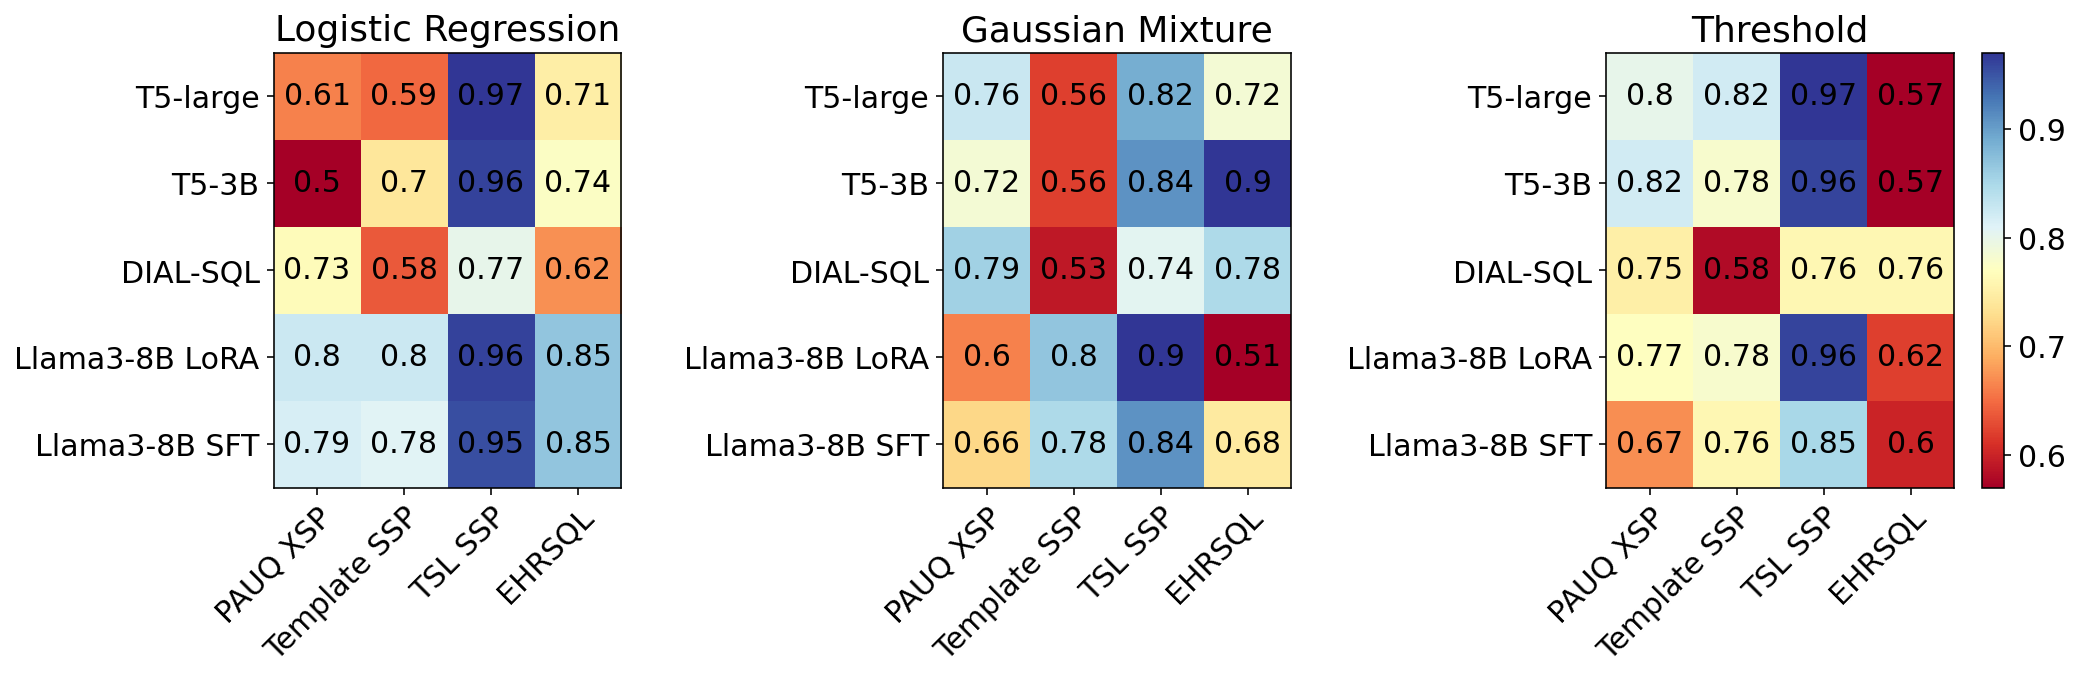

In [6]:
method_result_list = ['Logistic Regression', 'Gaussian Mixture', 'Threshold']

model_names = ['t5-large', 't5-3b', 'dailsql', 'llama3_lora', 'llama3_sft']
split_names = ['pauq_xsp', 'template_ssp', 'tsl_ssp', 'ehrsql']

fig, axs = plt.subplots(1, len(method_result_list), figsize=(17, 4))


for idx, method in enumerate(method_result_list):
    
    method_heat_matrix = np.zeros((len(model_names), len(split_names)))
    for i, model_name in enumerate(model_names):
        for j, split in enumerate(split_names):
            off_model_name = data_constants.MODEL_NAMES[model_name] 
            off_split_name = data_constants.SPLITS_NAMES[split]
            
            fbeta_score_value = metrics_result_dict[off_model_name][off_split_name][method]['f_score']['mean']
            
            method_heat_matrix[i][j] = fbeta_score_value

    off_model_name_list = [data_constants.MODEL_NAMES[model_name] for model_name in model_names]
    off_split_name_list = [data_constants.SPLITS_NAMES[split].replace(' split', '') for split in split_names]
    #https://matplotlib.org/stable/users/explain/colors/colormaps.html
    axs[idx].imshow(method_heat_matrix, cmap='RdYlBu')
    axs[idx].set_xticks(np.arange(len(off_split_name_list)), labels=off_split_name_list) 
    axs[idx].set_yticks(np.arange(len(off_model_name_list)), labels=off_model_name_list)
    
    plt.setp(axs[idx].get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
    
    for i in range(len(model_names)):
        for j in range(len(split_names)):
            text = axs[idx].text(j, i, method_heat_matrix[i][j],
                           ha="center", va="center", color='black')
            
    axs[idx].set_title(f"{method}")
    
ax=plt.gca() #get the current axes
PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
for PCM in ax.get_children():
    if isinstance(PCM, plt.cm.ScalarMappable):
        break
        
plt.colorbar(PCM, ax=ax)


fig.savefig('confidence estimation data/methods_heatmaps.png', dpi=300, bbox_inches='tight', transparent=True)

### Method per model per split accuracy table

In [298]:
model_for_method_metrics = dict()
metrics_list = ['Recall', 'Precision', 'F_{\beta}', 'AUC-ROC', '$\sigma$ F_{$\beta$}']
method_list = ['LR', 'GM', 'TR']



for model_name in metrics_result_dict.keys():
    model_for_method_metrics[model_name] = {'Logistic Regression': {key: 0 for key in metrics_list}, 
                                            'Gaussian Mixture':{key: 0 for key in metrics_list}, 
                                            'Threshold':{key: 0 for key in metrics_list}}
    for split in data_constants.SPLITS_NAMES.values():
        for method in metrics_result_dict[model_name][split].keys():
            
            recall = metrics_result_dict[model_name][split][method]['recall']['mean']
            precision = metrics_result_dict[model_name][split][method]['precision']['mean']
            f1 = metrics_result_dict[model_name][split][method]['f_score']['mean']
            f1_std = metrics_result_dict[model_name][split][method]['f_score']['std']
            auc = metrics_result_dict[model_name][split][method]['AUC-ROC']['mean']

            
            model_for_method_metrics[model_name][method]['Recall'] += recall
            model_for_method_metrics[model_name][method]['Precision'] += precision
            model_for_method_metrics[model_name][method]['F_{\beta}'] += f1
            model_for_method_metrics[model_name][method]['$\sigma$ F_{$\beta$}'] += f1_std
            
            model_for_method_metrics[model_name][method]['AUC-ROC'] += auc

            
for model_name in metrics_result_dict.keys():
    for method in model_for_method_metrics[model_name]:
        for metric in metrics_list:
            metrics_score = round(model_for_method_metrics[model_name][method][metric] / len(splits), 2)
            model_for_method_metrics[model_name][method][metric] = metrics_score        
        
df = pd.concat({k: pd.DataFrame(v).T for k, v in model_for_method_metrics.items()}, axis=0)
df = df[['Recall', 'Precision', 'F_{\beta}', 'AUC-ROC', '$\sigma$ F_{$\beta$}']]

df['$\sigma$ F_{$\beta$}'] = df['$\sigma$ F_{$\beta$}'].apply(lambda x: "\le 0.01" if x == 0 else x)
df

Recall  Precision  F_{eta}  AUC-ROC  \
T5-large       Logistic Regression    0.75       0.64      0.74     0.66   
               Gaussian Mixture       0.74       0.64      0.73     0.66   
               Threshold              0.86       0.59      0.83     0.81   
T5-3B          Logistic Regression    0.78       0.60      0.76     0.62   
               Gaussian Mixture       0.81       0.54      0.78     0.65   
               Threshold              0.90       0.41      0.85     0.80   
DIAL-SQL       Logistic Regression    0.85       0.38      0.77     0.46   
               Gaussian Mixture       0.87       0.38      0.80     0.57   
               Threshold              0.81       0.41      0.77     0.29   
Llama3-8B LoRA Logistic Regression    0.99       0.42      0.93     0.42   
               Gaussian Mixture       0.78       0.43      0.75     0.51   
               Threshold              0.89       0.40      0.84     0.63   
Llama3-8B SFT  Logistic Regression    0.99       0.39      0.92     0.38   
               Gaussian Mixture       0.82       0.48      0.80     0.61   
               Threshold              0.80       0.40      0.76     0.65   

                                   $\sigma$ F_{$eta$}  
T5-large       Logistic Regression                0.03  
               Gaussian Mixture                   0.09  
               Threshold                          0.02  
T5-3B          Logistic Regression                0.03  
               Gaussian Mixture                   0.06  
               Threshold                          0.02  
DIAL-SQL       Logistic Regression            \le 0.01  
               Gaussian Mixture               \le 0.01  
               Threshold                      \le 0.01  
Llama3-8B LoRA Logistic Regression            \le 0.01  
               Gaussian Mixture                   0.04  
               Threshold                          0.04  
Llama3-8B SFT  Logistic Regression            \le 0.01  
               Gaussian Mixture               \le 0.01  
               Threshold                      \le 0.01

### Method per model per split accuracy table

In [299]:
split_for_method_metrics = dict()
metrics_list = ['Recall', 'Precision', 'F_{\beta}', 'AUC-ROC', 'sigma']
method_list = ['LR', 'GM', 'TR']



for split in data_constants.SPLITS_NAMES.values():
    split_for_method_metrics[split] = {'Logistic Regression': {key: 0 for key in metrics_list}, 
                                        'Gaussian Mixture':{key: 0 for key in metrics_list}, 
                                        'Threshold':{key: 0 for key in metrics_list}}
    for model_name in metrics_result_dict.keys():
        for method in metrics_result_dict[model_name][split].keys():
            
            recall = metrics_result_dict[model_name][split][method]['recall']['mean']
            precision = metrics_result_dict[model_name][split][method]['precision']['mean']
            f1 = metrics_result_dict[model_name][split][method]['f_score']['mean']
            auc = metrics_result_dict[model_name][split][method]['AUC-ROC']['mean']
            f1_std = metrics_result_dict[model_name][split][method]['f_score']['std']
            
            split_for_method_metrics[split][method]['Recall'] += recall
            split_for_method_metrics[split][method]['Precision'] += precision
            split_for_method_metrics[split][method]['F_{\beta}'] += f1
            split_for_method_metrics[split][method]['AUC-ROC'] += auc
            split_for_method_metrics[split][method]['sigma'] += f1_std
            
for split in data_constants.SPLITS_NAMES.values(): 
    for method in model_for_method_metrics[model_name]:
        for metric in metrics_list:
            metrics_score = round(split_for_method_metrics[split][method][metric] / len(model_name_list), 2)
            split_for_method_metrics[split][method][metric] = metrics_score        
        
df = pd.concat({k: pd.DataFrame(v).T for k, v in split_for_method_metrics.items()}, axis=0)
df = df[['Recall', 'Precision', 'F_{\beta}', 'AUC-ROC', 'sigma']]

df['sigma'] = df['sigma'].apply(lambda x: "\le 0.01" if x == 0 else x)
df

Recall  Precision  F_{eta}  AUC-ROC  \
PAUQ XSP           Logistic Regression    0.82       0.39      0.75     0.50   
                   Gaussian Mixture       0.80       0.38      0.77     0.65   
                   Threshold              0.87       0.39      0.82     0.62   
Template SSP split Logistic Regression    0.89       0.25      0.80     0.30   
                   Gaussian Mixture       0.80       0.29      0.73     0.44   
                   Threshold              0.93       0.28      0.85     0.63   
TSL SSP split      Logistic Regression    0.98       0.63      0.96     0.59   
                   Gaussian Mixture       0.86       0.64      0.85     0.53   
                   Threshold              0.91       0.63      0.89     0.59   
EHRSQL             Logistic Regression    0.80       0.68      0.78     0.64   
                   Gaussian Mixture       0.74       0.68      0.74     0.79   
                   Threshold              0.69       0.47      0.67     0.71   

                                           sigma  
PAUQ XSP           Logistic Regression      0.01  
                   Gaussian Mixture         0.06  
                   Threshold                0.02  
Template SSP split Logistic Regression      0.02  
                   Gaussian Mixture         0.02  
                   Threshold                0.02  
TSL SSP split      Logistic Regression  \le 0.01  
                   Gaussian Mixture         0.05  
                   Threshold            \le 0.01  
EHRSQL             Logistic Regression      0.02  
                   Gaussian Mixture         0.02  
                   Threshold                0.03

### ROC-CURVE for each method

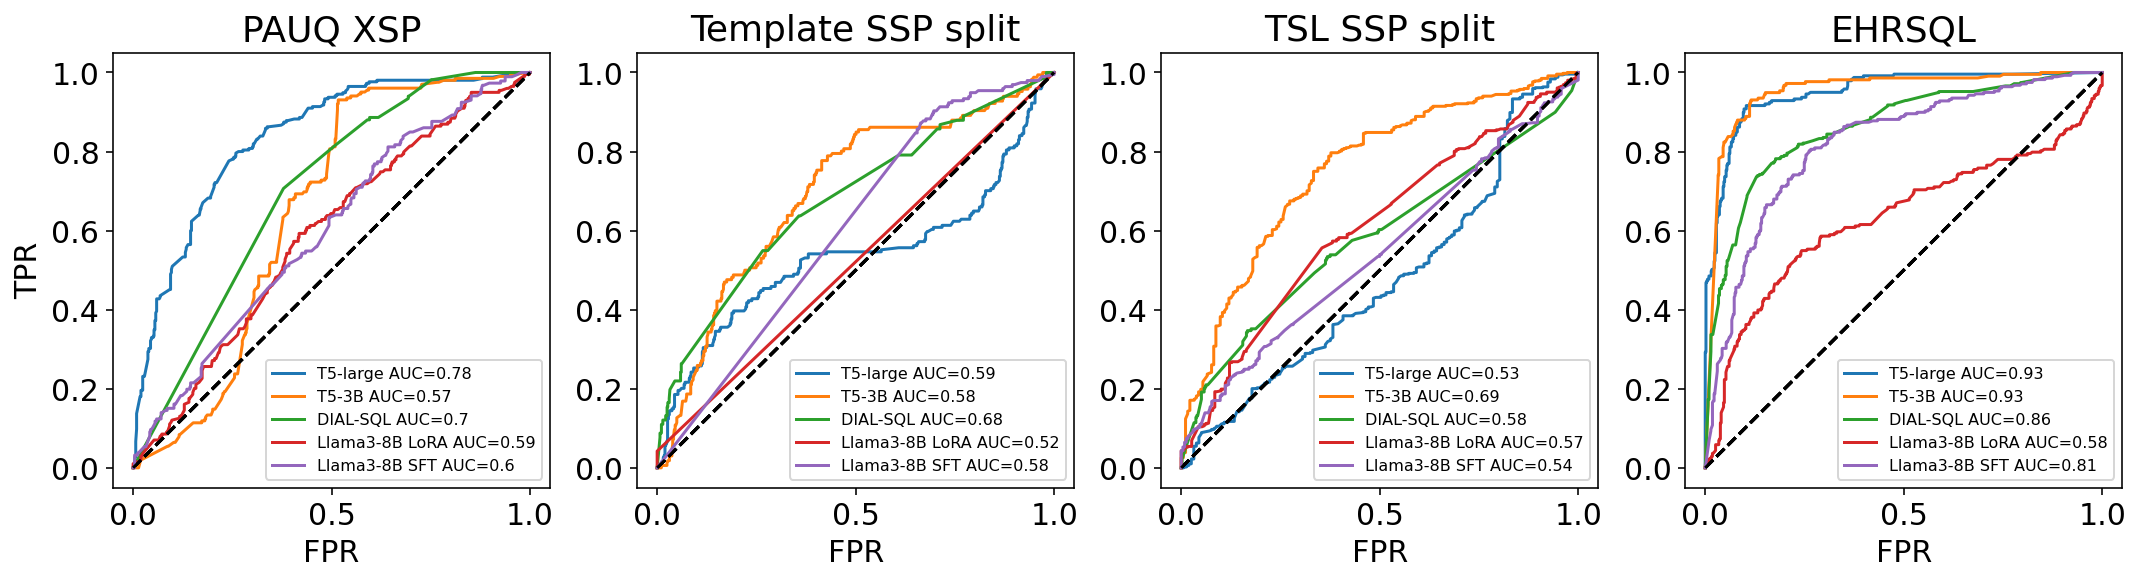

In [534]:
TARGET_METHOD = "Gaussian Mixture"

fig, axs = plt.subplots(1, len(splits), figsize=(18, 4))

split_to_model_list = dict()

for idx, split_name in enumerate(data_constants.SPLITS_NAMES.values()):
    for model in metrics_result_dict.keys():
        method_metrics = metrics_result_dict[model][split_name][TARGET_METHOD]
        
        auc = method_metrics['AUC-ROC']['mean']
        fpr, tpr = method_metrics['FPR'], method_metrics['TPR']
        
        # how to invert AUC scores
        if auc < 0.5:
            # print(split_name, model)
            auc = round(1 - auc, 2)
            fpr = 1 - fpr
            tpr = 1 - tpr
        
        axs[idx].plot(fpr, tpr, label=f"{model} AUC={auc}")
        axs[idx].plot([0, 1], [0, 1], linestyle='--', color='black')
        
        axs[idx].set_title(split_name)
        

axs[0].set_ylabel('TPR')
        
for ax in axs:
    ax.set_xlabel('FPR')
    ax.legend(prop={'size': 8})
    
plt.show()

fig.savefig(f'confidence estimation data/roc_curve_for_splits_for_{TARGET_METHOD}.png', dpi=300, bbox_inches='tight', transparent=True)

### Final error detection table


In [482]:
def evaluate_results_from_confidence_estimate(predicted_matrix, gold_matrix):
    seed_number = range(predicted_matrix.shape[1])
    predicted_targets = []
    score_list = []
    exec_acc_list, found_errors_list, sample_lost_list,result_ex_acc_list = [], [], [],[]
    
    for i in seed_number:
        predicted_list, gold_list = list(predicted_matrix[:, i]), list(gold_matrix[:, i])
        evaluation_list = []

        tp,fp,tn,fn = 0 ,0 ,0, 0
        for pred, gold in zip(predicted_list, gold_list):
            pred_exec_result = pred
            gold_exec_result = gold
            if pred_exec_result == 1 and gold_exec_result == 1:
                tp += 1
                # evaluation_list.append(1)
            elif pred_exec_result == 1 and gold_exec_result == 0:
                fp += 1
                # evaluation_list.append(0)
            elif pred_exec_result == 0 and gold_exec_result == 1:
                fn += 1
                # evaluation_list.append(0)
            elif pred_exec_result == 0 and gold_exec_result == 0:
                tn += 1
                # evaluation_list.append(1)
                
        execution_accuracy = 1 - np.mean(gold_list)
        found_errors = tp / (tp + fn)
        samples_lost = fp / len(gold_list)
        result_ex_accuracy = execution_accuracy - samples_lost# tn / len(gold_list)
        
        exec_acc_list.append(round(execution_accuracy, 3))
        found_errors_list.append(round(found_errors, 3))
        sample_lost_list.append(round(samples_lost, 3))
        result_ex_acc_list.append(round(result_ex_accuracy, 3))
    
    
    # print(result_ex_acc_list)
    mean_ex = round(np.mean(exec_acc_list), 3)
    mean_found_errors = round(np.mean(found_errors_list), 3)
    mean_lost_samples = round(np.mean(sample_lost_list), 3)
    mean_result_ex = round(np.mean(result_ex_acc_list), 3)
    std_result_ex = round(np.std(result_ex_acc_list), 3)
    
    
    return {"EX": mean_ex, "Found errors": mean_found_errors, "Traffic lost": mean_lost_samples, "Result EX": mean_result_ex, 'Result EX std': std_result_ex}
        
        


In [483]:
for model_name in model_name_list:
    off_model_name = data_constants.MODEL_NAMES[model_name]
    metrics_result_dict[off_model_name] = dict()
    for split_name in splits:
        off_split_name = data_constants.SPLITS_NAMES[split_name]
        print(off_model_name, off_split_name)
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            predicted_targets, _ = score_by_gmm(dev_sc, dev_tr, test_sc, test_tr)

            lr_penalized_results = evaluate_results_from_confidence_estimate(predicted_targets, test_tr)
            
            metrics_result_dict[off_model_name][off_split_name] = lr_penalized_results

T5-large PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 928424.42it/s]

(1076, 3) (1076, 3)
T5-large Template SSP split



100%|████████████████████████████████████| 986/986 [00:00<00:00, 1083748.36it/s]


(986, 3) (986, 3)
T5-large TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 505140.31it/s]


(986, 3) (986, 3)
T5-large EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 404525.02it/s]


(1167, 3) (1167, 3)
T5-3B PAUQ XSP


100%|██████████████████████████████████| 1076/1076 [00:00<00:00, 1025697.98it/s]


(1076, 3) (1076, 3)
T5-3B Template SSP split


100%|████████████████████████████████████| 986/986 [00:00<00:00, 1005979.99it/s]


(986, 3) (986, 3)
T5-3B TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 788180.63it/s]


(986, 3) (986, 3)
T5-3B EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 582569.96it/s]

(1167, 3) (1167, 3)


DIAL-SQL PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 684836.28it/s]

(1076, 1) (1076, 1)


DIAL-SQL Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 912328.20it/s]

(986, 1) (986, 1)
DIAL-SQL TSL SSP split



100%|█████████████████████████████████████| 986/986 [00:00<00:00, 886703.20it/s]


(986, 1) (986, 1)
DIAL-SQL EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 458181.48it/s]


(1167, 1) (1167, 1)
Llama3-8B LoRA PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 835908.71it/s]


(1076, 3) (1076, 3)
Llama3-8B LoRA Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 853049.45it/s]


(986, 3) (986, 3)
Llama3-8B LoRA TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 579294.54it/s]


(986, 3) (986, 3)
Llama3-8B LoRA EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 413094.17it/s]

(1167, 3) (1167, 3)


Llama3-8B SFT PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 909709.96it/s]


(1076, 3) (1076, 3)
Llama3-8B SFT Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 895341.79it/s]


(986, 3) (986, 3)
Llama3-8B SFT TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 620492.68it/s]


(986, 3) (986, 3)
Llama3-8B SFT EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 489328.48it/s]


(1167, 3) (1167, 3)


In [484]:
gmm_df = pd.concat({k: pd.DataFrame(v).T for k, v in metrics_result_dict.items()}, axis=0)


gmm_df['Result EX std'] = gmm_df['Result EX std'].apply(lambda x: "\le 0.01" if x == 0 else x)

print('Found errors: ', gmm_df['Found errors'].mean())
print('Traffic lost: ', gmm_df['Traffic lost'].mean())
print('Result EX: ', gmm_df['Result EX'].mean())


gmm_df

Found errors:  0.7984000000000001
Traffic lost:  0.36365
Result EX:  0.25065000000000004


EX  Found errors  Traffic lost  \
T5-large       PAUQ XSP            0.634         0.795         0.218   
               Template SSP split  0.690         0.624         0.461   
               TSL SSP split       0.243         0.828         0.201   
               EHRSQL              0.687         0.705         0.034   
T5-3B          PAUQ XSP            0.709         0.816         0.444   
               Template SSP split  0.738         0.608         0.335   
               TSL SSP split       0.282         0.852         0.170   
               EHRSQL              0.712         0.919         0.086   
DIAL-SQL       PAUQ XSP            0.765         0.982         0.577   
               Template SSP split  0.860         0.868         0.846   
               TSL SSP split       0.664         0.854         0.636   
               EHRSQL              0.542         0.793         0.105   
Llama3-8B LoRA PAUQ XSP            0.717         0.660         0.373   
               Template SSP split  0.673         0.958         0.673   
               TSL SSP split       0.296         0.929         0.265   
               EHRSQL              0.643         0.546         0.403   
Llama3-8B SFT  PAUQ XSP            0.731         0.756         0.449   
               Template SSP split  0.697         0.907         0.524   
               TSL SSP split       0.361         0.880         0.342   
               EHRSQL              0.640         0.688         0.131   

                                   Result EX Result EX std  
T5-large       PAUQ XSP                0.415         0.097  
               Template SSP split      0.229          0.24  
               TSL SSP split           0.043         0.016  
               EHRSQL                  0.654         0.007  
T5-3B          PAUQ XSP                0.265         0.157  
               Template SSP split      0.404         0.228  
               TSL SSP split           0.112         0.021  
               EHRSQL                  0.626         0.027  
DIAL-SQL       PAUQ XSP                0.188      \le 0.01  
               Template SSP split      0.014      \le 0.01  
               TSL SSP split           0.028      \le 0.01  
               EHRSQL                  0.437      \le 0.01  
Llama3-8B LoRA PAUQ XSP                0.344         0.068  
               Template SSP split      0.000      \le 0.01  
               TSL SSP split           0.032         0.026  
               EHRSQL                  0.239         0.202  
Llama3-8B SFT  PAUQ XSP                0.282         0.002  
               Template SSP split      0.173         0.009  
               TSL SSP split           0.019         0.016  
               EHRSQL                  0.509         0.042

In [485]:
for model_name in model_name_list:
    off_model_name = data_constants.MODEL_NAMES[model_name]
    metrics_result_dict[off_model_name] = dict()
    for split_name in splits:
        off_split_name = data_constants.SPLITS_NAMES[split_name]
        print(off_model_name, off_split_name)
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            predicted_targets, _ = score_by_logreg(dev_sc, dev_tr, test_sc, test_tr)

            lr_penalized_results = evaluate_results_from_confidence_estimate(predicted_targets, test_tr)
            
            metrics_result_dict[off_model_name][off_split_name] = lr_penalized_results

T5-large PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 478231.55it/s]

(1076, 3) (1076, 3)


T5-large Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 839712.44it/s]

(986, 3) (986, 3)
T5-large TSL SSP split



100%|█████████████████████████████████████| 986/986 [00:00<00:00, 871934.16it/s]


(986, 3) (986, 3)
T5-large EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 426557.98it/s]


(1167, 3) (1167, 3)
T5-3B PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 667416.61it/s]


(1076, 3) (1076, 3)
T5-3B Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 674866.80it/s]


(986, 3) (986, 3)
T5-3B TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 871750.37it/s]


(986, 3) (986, 3)
T5-3B EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 564041.57it/s]


(1167, 3) (1167, 3)
DIAL-SQL PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 936516.10it/s]


(1076, 1) (1076, 1)
DIAL-SQL Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 818927.47it/s]


(986, 1) (986, 1)
DIAL-SQL TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 724905.13it/s]


(986, 1) (986, 1)
DIAL-SQL EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 509180.56it/s]


(1167, 1) (1167, 1)
Llama3-8B LoRA PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 681012.69it/s]


(1076, 3) (1076, 3)
Llama3-8B LoRA Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 976064.14it/s]


(986, 3) (986, 3)
Llama3-8B LoRA TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 509245.63it/s]


(986, 3) (986, 3)
Llama3-8B LoRA EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 562938.79it/s]


(1167, 3) (1167, 3)
Llama3-8B SFT PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 629174.84it/s]


(1076, 3) (1076, 3)
Llama3-8B SFT Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 880848.51it/s]


(986, 3) (986, 3)
Llama3-8B SFT TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 723383.55it/s]


(986, 3) (986, 3)
Llama3-8B SFT EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 539842.59it/s]

(1167, 3) (1167, 3)


In [487]:
logreg_df = pd.concat({k: pd.DataFrame(v).T for k, v in metrics_result_dict.items()}, axis=0)
print('Found errors: ', logreg_df['Found errors'].mean())
print('Traffic lost: ', logreg_df['Traffic lost'].mean())
print('Result EX: ', logreg_df['Result EX'].mean())

logreg_df['Result EX std'] = logreg_df['Result EX std'].apply(lambda x: "<0.01" if x == 0 else x)

logreg_df

Found errors:  0.8725999999999999
Traffic lost:  0.46895
Result EX:  0.14534999999999998


EX  Found errors  Traffic lost  \
T5-large       PAUQ XSP            0.634         0.601         0.111   
               Template SSP split  0.690         0.698         0.644   
               TSL SSP split       0.243         1.000         0.243   
               EHRSQL              0.687         0.694         0.030   
T5-3B          PAUQ XSP            0.709         0.523         0.262   
               Template SSP split  0.738         0.885         0.718   
               TSL SSP split       0.282         1.000         0.282   
               EHRSQL              0.712         0.724         0.017   
DIAL-SQL       PAUQ XSP            0.765         0.958         0.759   
               Template SSP split  0.860         0.934         0.859   
               TSL SSP split       0.664         0.922         0.653   
               EHRSQL              0.542         0.601         0.043   
Llama3-8B LoRA PAUQ XSP            0.717         1.000         0.717   
               Template SSP split  0.673         0.958         0.673   
               TSL SSP split       0.296         1.000         0.296   
               EHRSQL              0.643         1.000         0.643   
Llama3-8B SFT  PAUQ XSP            0.731         1.000         0.731   
               Template SSP split  0.697         0.954         0.697   
               TSL SSP split       0.361         1.000         0.361   
               EHRSQL              0.640         1.000         0.640   

                                   Result EX Result EX std  
T5-large       PAUQ XSP                0.523         0.003  
               Template SSP split      0.046         0.008  
               TSL SSP split           0.000         <0.01  
               EHRSQL                  0.657         0.005  
T5-3B          PAUQ XSP                0.448         0.259  
               Template SSP split      0.020         0.008  
               TSL SSP split           0.000         <0.01  
               EHRSQL                  0.695         0.004  
DIAL-SQL       PAUQ XSP                0.006         <0.01  
               Template SSP split      0.002         <0.01  
               TSL SSP split           0.011         <0.01  
               EHRSQL                  0.499         <0.01  
Llama3-8B LoRA PAUQ XSP                0.000         <0.01  
               Template SSP split      0.000         <0.01  
               TSL SSP split           0.000         <0.01  
               EHRSQL                  0.000         <0.01  
Llama3-8B SFT  PAUQ XSP                0.000         <0.01  
               Template SSP split      0.000         <0.01  
               TSL SSP split           0.000         <0.01  
               EHRSQL                  0.000         <0.01

In [488]:
for model_name in model_name_list:
    off_model_name = data_constants.MODEL_NAMES[model_name]
    metrics_result_dict[off_model_name] = dict()
    for split_name in splits:
        off_split_name = data_constants.SPLITS_NAMES[split_name]
        print(off_model_name, off_split_name)
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            predicted_targets, _ = score_by_thresh(dev_sc, dev_tr, test_sc, test_tr)

            lr_penalized_results = evaluate_results_from_confidence_estimate(predicted_targets, test_tr)
            
            metrics_result_dict[off_model_name][off_split_name] = lr_penalized_results

T5-large PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 851844.30it/s]

(1076, 3) (1076, 3)
T5-large Template SSP split



100%|█████████████████████████████████████| 986/986 [00:00<00:00, 736524.26it/s]


(986, 3) (986, 3)
T5-large TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 907921.79it/s]


(986, 3) (986, 3)
T5-large EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 617167.16it/s]


(1167, 3) (1167, 3)
T5-3B PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 942186.03it/s]


(1076, 3) (1076, 3)
T5-3B Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 922297.89it/s]


(986, 3) (986, 3)
T5-3B TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 663604.58it/s]


(986, 3) (986, 3)
T5-3B EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 550962.72it/s]

(1167, 3) (1167, 3)


DIAL-SQL PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 866398.75it/s]


(1076, 1) (1076, 1)
DIAL-SQL Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 952679.97it/s]


(986, 1) (986, 1)
DIAL-SQL TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 738497.10it/s]


(986, 1) (986, 1)
DIAL-SQL EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 429364.28it/s]

(1167, 1) (1167, 1)


Llama3-8B LoRA PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 837459.84it/s]


(1076, 3) (1076, 3)
Llama3-8B LoRA Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 992937.27it/s]


(986, 3) (986, 3)
Llama3-8B LoRA TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 802870.07it/s]


(986, 3) (986, 3)
Llama3-8B LoRA EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 409055.05it/s]


(1167, 3) (1167, 3)
Llama3-8B SFT PAUQ XSP


100%|███████████████████████████████████| 1076/1076 [00:00<00:00, 918037.25it/s]


(1076, 3) (1076, 3)
Llama3-8B SFT Template SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 879537.16it/s]


(986, 3) (986, 3)
Llama3-8B SFT TSL SSP split


100%|█████████████████████████████████████| 986/986 [00:00<00:00, 731443.89it/s]

(986, 3) (986, 3)


Llama3-8B SFT EHRSQL


100%|███████████████████████████████████| 1167/1167 [00:00<00:00, 566194.65it/s]

(1167, 3) (1167, 3)


In [489]:
thresh_df = pd.concat({k: pd.DataFrame(v).T for k, v in metrics_result_dict.items()}, axis=0)

print('Found errors: ', thresh_df['Found errors'].mean())
print('Traffic lost: ', thresh_df['Traffic lost'].mean())
print('Result EX: ', thresh_df['Result EX'].mean())

df['Result EX std'] = thresh_df['Result EX std'].apply(lambda x: "<0.01" if x == 0 else x)

thresh_df

Found errors:  0.8724000000000001
Traffic lost:  0.4711
Result EX:  0.14320000000000002


EX  Found errors  Traffic lost  \
T5-large       PAUQ XSP            0.634         0.830         0.203   
               Template SSP split  0.690         1.000         0.690   
               TSL SSP split       0.243         1.000         0.243   
               EHRSQL              0.687         0.591         0.237   
T5-3B          PAUQ XSP            0.709         0.903         0.338   
               Template SSP split  0.738         1.000         0.738   
               TSL SSP split       0.282         1.000         0.282   
               EHRSQL              0.712         0.699         0.711   
DIAL-SQL       PAUQ XSP            0.765         0.874         0.451   
               Template SSP split  0.860         1.000         0.860   
               TSL SSP split       0.664         1.000         0.664   
               EHRSQL              0.542         0.779         0.099   
Llama3-8B LoRA PAUQ XSP            0.717         0.929         0.615   
               Template SSP split  0.673         0.932         0.641   
               TSL SSP split       0.296         1.000         0.296   
               EHRSQL              0.643         0.699         0.585   
Llama3-8B SFT  PAUQ XSP            0.731         0.769         0.460   
               Template SSP split  0.697         0.901         0.568   
               TSL SSP split       0.361         0.890         0.314   
               EHRSQL              0.640         0.652         0.427   

                                   Result EX  Result EX std  
T5-large       PAUQ XSP                0.431          0.026  
               Template SSP split      0.000          0.000  
               TSL SSP split           0.000          0.000  
               EHRSQL                  0.450          0.317  
T5-3B          PAUQ XSP                0.371          0.031  
               Template SSP split      0.000          0.000  
               TSL SSP split           0.000          0.000  
               EHRSQL                  0.001          0.002  
DIAL-SQL       PAUQ XSP                0.314          0.000  
               Template SSP split      0.000          0.000  
               TSL SSP split           0.000          0.000  
               EHRSQL                  0.444          0.000  
Llama3-8B LoRA PAUQ XSP                0.103          0.029  
               Template SSP split      0.032          0.045  
               TSL SSP split           0.000          0.000  
               EHRSQL                  0.057          0.026  
Llama3-8B SFT  PAUQ XSP                0.271          0.055  
               Template SSP split      0.130          0.183  
               TSL SSP split           0.047          0.066  
               EHRSQL                  0.213          0.251

### Overall results

In [490]:
all_methods_metrics = {"Gaussian Mixture": {"Found errors": round(gmm_df['Found errors'].mean(), 3),
                                           "Traffic lost": round(gmm_df['Traffic lost'].mean(),3),
                                           "Result EX": round(gmm_df['Result EX'].mean(), 3)},
                      "Logistic Regression": {"Found errors": round(logreg_df['Found errors'].mean(), 3),
                                           "Traffic lost": round(logreg_df['Traffic lost'].mean(),3),
                                           "Result EX": round(logreg_df['Result EX'].mean(), 3)},
                      "Threshold": {"Found errors": round(thresh_df['Found errors'].mean(), 3),
                                    "Traffic lost": round(thresh_df['Traffic lost'].mean(),3),
                                    "Result EX": round(thresh_df['Result EX'].mean(), 3)}
                      }


df = pd.DataFrame.from_dict(all_methods_metrics).T
df

,Found errors,Traffic lost,Result EX
Gaussian Mixture,0.798,0.364,0.251
Logistic Regression,0.873,0.469,0.145
Threshold,0.872,0.471,0.143
